# Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
Change directory to where this file is located
"""
%cd '/content/drive/MyDrive/MLVU/HW4/'

/content/drive/MyDrive/MLVU/HW4


## Module Import

In [ ]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets.cifar10 import load_data

from tensorflow.keras.layers import Resizing, Input, Activation, Dense, LayerNormalization, Add, Concatenate

## Global Parameters

In [ ]:
img_size = 32
in_channels = 3

num_classes = 10

batch_size = 64
patch_size = 4

num_patches = (img_size // patch_size)**2


num_transformer_layers = 8
num_heads_of_MSA = 8
proj_dimension = 128
MLP_proj_dimension = 1024

## Utils

In [ ]:
def plot_dataset(images, labels, grid_width, grid_height, figure_width=5, figure_height=5, y_hats=None):
    """
    Plots image and labels.

    Do NOT modify this method.
    """
    f, ax = plt.subplots(grid_height, grid_width)
    f.set_size_inches(figure_width, figure_height)
    img_idx = 0
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            image = images[img_idx]
            label = labels[img_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[img_idx])
                if int(labels[img_idx]) != label_idx:
                    title_color = 'r'
            label = InputPipelineBuilder.LABELS[label_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            ax[i][j].imshow(image, aspect='auto')
            img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)
    plt.show()

def plot_history(history):
    """
    Plots training history.
    
    Do NOT modify this method.
    """
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

## [0] Data Loader (CIFAR-10)

In [ ]:
class InputPipelineBuilder:
    """
    CIFAR10 Input Pipeline
    """    
    IMG_SIZE = (img_size, img_size)
    LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    def __init__(self, valid_size=0.2):
        """
        Loads and splits CIFAR10 to train, validation, and test sets.

        Do NOT modify this method.
        """
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_size)
        self.x = {'train':x_train, 'valid':x_valid, 'test':x_test}
        self.y = {'train':y_train, 'valid':y_valid, 'test':y_test}
        
    def get_dataset(self, generator, subset='train'):
        """
        Creates a tf.dataset to load input images augmented by the given generator.

        Do NOT modify this method.
        """
        x = self.x[subset]
        y = self.y[subset]
        def gen():
            for images, labels in generator.flow(x, y, batch_size=1, shuffle=False):
                yield Resizing(img_size, img_size)(images[0]), labels[0]
        
        ds = tf.data.Dataset.from_generator(
            gen, 
            output_signature=(
                tf.TensorSpec(shape=(*InputPipelineBuilder.IMG_SIZE, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(1,), dtype=tf.float32)))
        
        return ds, len(y)

In [ ]:
"""
Builds a CIFAR10 input pipeline, and performs data augmentation for training data.
"""
input_pipeline_builder = InputPipelineBuilder()

train_generator = ImageDataGenerator(rescale=1./255)
valid_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
"""
Utilize TF dataset methods to expedite I/O.
"""

train_ds_preprocessed, train_steps = input_pipeline_builder.get_dataset(train_generator, subset='train')
valid_ds_preprocessed, valid_steps = input_pipeline_builder.get_dataset(valid_generator, subset='valid')
test_ds_preprocessed, test_steps = input_pipeline_builder.get_dataset(test_generator, subset='test')

train_ds = train_ds_preprocessed.shuffle(1000).batch(16)
valid_ds = valid_ds_preprocessed.batch(16)

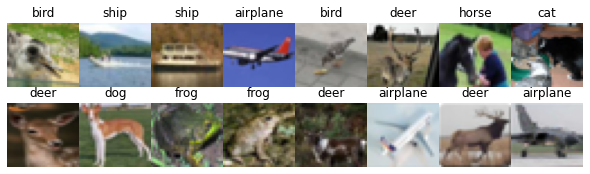

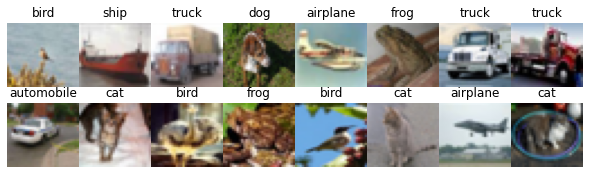

In [ ]:
images, labels = next(iter(train_ds.take(1)))
plot_dataset(images, labels, grid_width=8, grid_height=2, figure_width=8, figure_height=2)
images, labels = next(iter(valid_ds.take(1)))
plot_dataset(images, labels, grid_width=8, grid_height=2, figure_width=8, figure_height=2)

## [1] Data Preprocessing : Transfromation of Image to Patches

In [ ]:
class make_patches(Layer):
    def __init__(self, batch_size, patch_size):
        super(make_patches, self).__init__()
        self.batch_size = batch_size
        self.patch_size = patch_size

    def call(self, images):
        """
        Make patches from input 
        (Hint. Use tf.image.extract_patches function)

        Output: patches ; (batch_size, "Num of patches", patch_size**2 * in_channels)

        """
        ### Q1.(a) ###
        patches = tf.image.extract_patches(
            images = images, 
            sizes = [1,self.patch_size,self.patch_size,1],
            strides = [1,self.patch_size,self.patch_size,1],
            rates = [1,1,1,1],
            padding = "VALID")
        ### Q1.(a) ###
        
        #B,P1,P2,K = tf.shape(patches)
        
        patches=tf.reshape(patches,(tf.shape(patches)[0],tf.shape(patches)[1]*tf.shape(patches)[2],tf.shape(patches)[3]))
        return patches

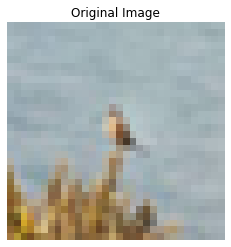

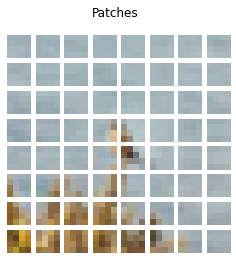

In [ ]:
sample_image = images[:1]
sample_patches = make_patches(batch_size, patch_size)(sample_image)

## Plot original image
plt.figure(figsize=(4,4))
plt.imshow(sample_image[0])
plt.title('Original Image')
plt.axis('off')

## Plot patches
n_patch = int(np.sqrt(sample_patches.shape[1]))
plt.figure(figsize=(4,4))
for i, sample_patch in enumerate(sample_patches[0]):
    ax = plt.subplot(n_patch, n_patch, i+1)
    plt.imshow(tf.reshape(sample_patch, (patch_size,patch_size,sample_image.shape[-1])))
    plt.axis('off')
plt.suptitle('Patches')

plt.show()

## [2] Model

In [ ]:
def Positional_Embedding(num_patches, patch_dim):
    _w = tf.repeat(tf.range(start=0, limit=patch_dim//2, delta=1, dtype=tf.float32), 2)
    w = tf.reshape(1/(10000**(2*(_w+1)/patch_dim)), (1,-1))
    t = tf.reshape(tf.range(start=0, limit=num_patches, delta=1, dtype=tf.float32), (-1,1))

    w_t = t*w

    mask_even = tf.reshape(tf.repeat(tf.constant([[1,0]], dtype=tf.float32), patch_dim//2 * num_patches, axis=0), (num_patches, patch_dim))
    mask_odd = tf.reshape(tf.repeat(tf.constant([[0,1]], dtype=tf.float32), patch_dim//2 * num_patches, axis=0), (num_patches, patch_dim))

    _embedding = tf.math.sin(w_t)*mask_even + tf.math.cos(w_t)*mask_odd
    embedding = tf.expand_dims(_embedding, 0)

    return embedding

In [ ]:
class patches_encoder(Layer):
    def __init__(self, num_patches, proj_dimension):
        super(patches_encoder, self).__init__()

        self.num_patches = num_patches
        self.proj_dimension = proj_dimension

        self.encoding_layer = Dense(proj_dimension)

    def call(self, x, training=None):
        positional_embedding = Positional_Embedding(self.num_patches, self.proj_dimension)
        # pe = tf.zeros((self.num_patches, self.proj_dimension))
        
        x = self.encoding_layer(x) + positional_embedding
        # x = self.encoding_layer(x) + pe

        return x

In [ ]:
class MLP(Layer):
    def __init__(self, dimensions):
        super(MLP, self).__init__()

        self.layer1 = Dense(dimensions[0], activation="gelu")
        self.layer2 = Dense(dimensions[1], activation="gelu")

    def call(self, x, training=None):
        x = self.layer1(x)
        x = self.layer2(x)

        return x

In [ ]:
class MSA(Layer):
    """
    Multi-Headed Self Attention layer of the transformer

    cf)
    SA_proj_dim(Each head's dimension) := proj_dimension / num_heads_of_MSA

    Zi(Attention Value) = softmax(Qi @ Ki^T / sqrt(SA_proj_dim)) @ Vi
    
    Output = FC layer(concat(all Zi)) ; (batch_size, "Num of Patches" + 1(CLS), proj_dimension)

    """
    def __init__(self, num_heads_of_MSA, proj_dimension):
        super(MSA, self).__init__()

        self.num_heads_of_MSA = num_heads_of_MSA
        self.proj_dimension = proj_dimension
        self.SA_proj_dim = proj_dimension//num_heads_of_MSA

        ### Q1. (b) ###
        self.W0 = Dense(self.proj_dimension, use_bias = False)
        self.WQi = []
        self.WKi = []
        self.WVi = []
        for _ in range(self.num_heads_of_MSA):
            self.WQi.append(Dense(self.SA_proj_dim, use_bias = False))
            self.WKi.append(Dense(self.SA_proj_dim, use_bias = False))
            self.WVi.append(Dense(self.SA_proj_dim, use_bias = False))

        ### Q1. (b) ###

    def call(self, x, training=None):
        ### Q1. (b) ###
        self.Zi = []
        for i in range(self.num_heads_of_MSA):
            Q = self.WQi[i](x)
            K = self.WKi[i](x)
            V = self.WVi[i](x)
            #print("Q", self.WQi[i](x).shape)
            #print("Q @ K.T", tf.keras.backend.batch_dot(self.WQi[i](x),self.WKi[i](x),axes=[2, 2]).shape)
            #print("V", self.WVi[i](x).shape)
            tmp = tf.nn.softmax(tf.keras.backend.batch_dot(Q, K, axes=[2, 2])/tf.math.sqrt(float(self.SA_proj_dim)))
            self.Zi.append(tf.keras.backend.batch_dot(tmp,V ,axes=[2,1]))
        
        Z = Concatenate()(self.Zi)
        out = self.W0(Z)
        
        ### Q1. (b) ###

        return out

In [ ]:
class ViT(Model):
    """
    cf)
    z_L_0 : First token of the output of last transformer layer
    output_logits : FC(MLP(LN(z_L_0))) ; (batch_size, num_classes(10)) ; before softmax

    """
    def __init__(self, batch_size, num_patches, patch_size, num_transformer_layers, num_heads_of_MSA, proj_dimension, MLP_proj_dimension):
        super(ViT, self).__init__()
        self.num_transformer_layers = num_transformer_layers
        self.num_heads_of_MSA = num_heads_of_MSA
        self.patch_size = patch_size

        self.make_patches = make_patches(batch_size, patch_size)
        self.patches_encoder = patches_encoder(num_patches, proj_dimension)

        self.layer_norm = []
        self.MSA = []
        self.MLP = []
        
        for i in range(num_transformer_layers):
            self.layer_norm.append(LayerNormalization(epsilon=1e-6))
            self.layer_norm.append(LayerNormalization(epsilon=1e-6))

            self.MLP.append(MLP(dimensions=[MLP_proj_dimension, proj_dimension]))

            self.MSA.append(MSA(num_heads_of_MSA, proj_dimension))

        self.layer_norm.append(LayerNormalization(epsilon=1e-6))
        self.MLP.append(MLP(dimensions=[MLP_proj_dimension*2, MLP_proj_dimension]))
        self.final_layer = Dense(num_classes)
        

    def call(self, x, training=None):
        x = self.make_patches(x)
        x = self.patches_encoder(x)
        CLS = tf.repeat(tf.zeros((1,1,proj_dimension)), tf.shape(x)[0], axis=0)
        x = tf.concat([CLS, x], axis=1)

        ### Q1.(c) ###
        for i in range(num_transformer_layers):
            x_skip = x
            x = self.layer_norm[2*i](x)
            x = self.MSA[i](x)
            x = Add()([x,x_skip])
            x_skip2 = x
            x = self.layer_norm[2*i+1](x)
            x = self.MLP[i](x)
            x = Add()([x,x_skip2])
        x = x[:,0,:]
        x = self.layer_norm[num_transformer_layers*2](x)
        x = self.MLP[num_transformer_layers](x)
        output_logits = self.final_layer(x)
        ### Q1.(c) ###

        return output_logits

In [ ]:
model_ViT = ViT(batch_size, num_patches, patch_size, num_transformer_layers, num_heads_of_MSA, proj_dimension, MLP_proj_dimension)

In [ ]:
model_ViT.build((None,img_size,img_size,in_channels))
model_ViT.call(Input((img_size,img_size,in_channels)))
model_ViT.summary()

Model: "vi_t_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 make_patches_32 (make_patch  (None, 64, 48)           0         
 es)                                                             
                                                                 
 patches_encoder_28 (patches  (None, 64, 128)          6272      
 _encoder)                                                       
                                                                 
 layer_normalization_476 (La  (None, 65, 128)          256       
 yerNormalization)                                               
                                                                 
 layer_normalization_477 (La  (None, 65, 128)          256       
 yerNormalization)                                               
                                                                 
 layer_normalization_478 (La  (None, 65, 128)          256 

## [3] Training

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
          tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
]

model_ViT.compile(optimizer, loss, metrics=metrics)

In [ ]:
callbacks = []
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3))

In [ ]:
train_ds_preprocessed, train_steps = input_pipeline_builder.get_dataset(train_generator, subset='train')
valid_ds_preprocessed, valid_steps = input_pipeline_builder.get_dataset(valid_generator, subset='valid')
test_ds_preprocessed, test_steps = input_pipeline_builder.get_dataset(test_generator, subset='test')

train_ds, train_steps = train_ds_preprocessed.shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE), train_steps//batch_size
valid_ds, valid_steps = valid_ds_preprocessed.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE), valid_steps//batch_size
test_ds, test_steps = test_ds_preprocessed.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE), test_steps//batch_size

Epoch 1/10
625/625 [==============================] - 286s 402ms/step - loss: 1.8199 - accuracy: 0.3293 - top-5-accuracy: 0.8268 - val_loss: 1.5903 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.9046
Epoch 2/10
625/625 [==============================] - 243s 389ms/step - loss: 1.5078 - accuracy: 0.4538 - top-5-accuracy: 0.9100 - val_loss: 1.4129 - val_accuracy: 0.4900 - val_top-5-accuracy: 0.9232
Epoch 3/10
625/625 [==============================] - 243s 389ms/step - loss: 1.3853 - accuracy: 0.4997 - top-5-accuracy: 0.9284 - val_loss: 1.3762 - val_accuracy: 0.5056 - val_top-5-accuracy: 0.9297
Epoch 4/10
625/625 [==============================] - 244s 390ms/step - loss: 1.2906 - accuracy: 0.5351 - top-5-accuracy: 0.9399 - val_loss: 1.3169 - val_accuracy: 0.5319 - val_top-5-accuracy: 0.9375
Epoch 5/10
625/625 [==============================] - 246s 394ms/step - loss: 1.2096 - accuracy: 0.5654 - top-5-accuracy: 0.9490 - val_loss: 1.3139 - val_accuracy: 0.5414 - val_top-5-accuracy: 0.9417


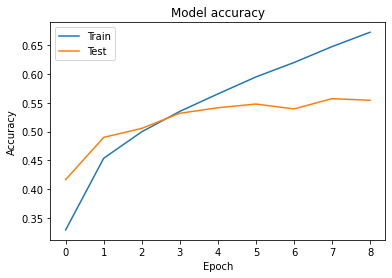

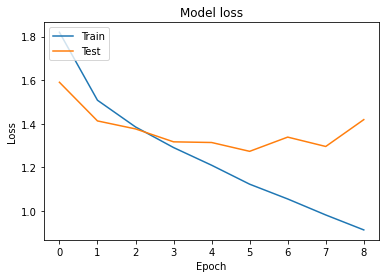

In [ ]:
history = model_ViT.fit(train_ds,
                  steps_per_epoch=train_steps,
                  validation_data=valid_ds,
                  validation_steps=valid_steps,
                  callbacks=callbacks,
                  epochs=10,
                  verbose=1)

plot_history(history)

## Test

156/156 [==============================] - 34s 219ms/step - loss: 1.4123 - accuracy: 0.5511 - top-5-accuracy: 0.9397


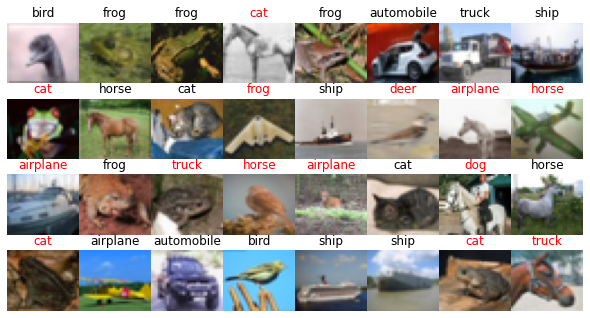

In [ ]:
"""
Measure test accuracy
"""

model_ViT.evaluate(test_ds, steps=test_steps)

images, labels = next(iter(test_ds_preprocessed.shuffle(100).batch(32).take(1)))
y_hats = np.argmax(model_ViT.predict(images), axis=1)
plot_dataset(images, labels, grid_width=8, grid_height=4, figure_width=8, figure_height=4, y_hats=y_hats)

## D) Describe your opinion on ViTøs pros and cons comparing to conventional CNN models for vision tasks. Which one seems better on your judgement

First of all we know that it takes a long time to train ViT models to achive a good accuracy, on the original papers model they trained for approx. 30 days using google infrastructure at a cost of around 480k dollars for training one model. However when trained for that long on a very large-scale dataset it beats the baseline model by a small amount. However when trained on smaller-scale datasets (imagenet, Imagenet-21K - which actually is quite big as well) the ViT models do not outperform baseline models (conventional CNNs). 

The reason for why ViTs need that much more data and training is because these models do not imply inductive bias (as conventional CNNs), and instead the ViT attend the entire image (even at the lower layers). Because of the fact that many signals actually comes from nearby areas, the ViT models have to learn that fact - which takes more training and more data. 

On the other hand the ViT models are able to model beyond the spatial locality and positional invariance (inductive bias) meaning it can model signals that is not comming from nearby area (which is not really possible in conventional CNNS), hence this model can achive a little higher performance when trained for a long time on a very large dataset.

In my judgement I would say conventional CNNs does a better job on visual tasks compared to ViT models, since the better performance of the ViTs are not cost effective, since it is very expensive to train a ViT that outperforms the conventional CNNs (baselines). 